In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.style.use('seaborn-v0_8-bright')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True

import cv2 as cv

from skimage import measure, morphology
from skimage.measure import find_contours
from skimage.morphology import disk
from skimage import io
from skimage import measure

from scipy.spatial.distance import cdist
from scipy import ndimage

### Analysing clusters from unconstrained neuruloid 

- Obtain binary image from TBXT image by thresholding
- Use sk morphology regionprops to detect regions

In [2]:
unconstrained_img_path = "../image/unconstrained.tif"
img = io.imread(unconstrained_img_path)
pixel_size = 0.4360802
x, y = np.shape(img)[0], np.shape(img)[1]
print(np.shape(img))

(5359, 5566, 4)


In [3]:
dapi, sox2, ph, tbxt = [img[:,:,i] for i in range(4)]

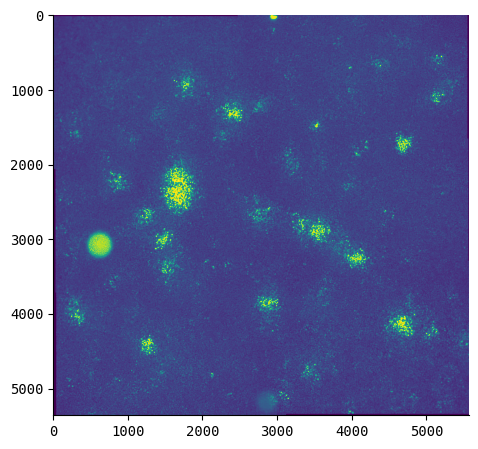

In [4]:
fig, ax = plt.subplots(figsize=(x/1000, y/1000))
ax.imshow(tbxt)

In [5]:
threshold = np.percentile(tbxt, 99)
bin_image = tbxt>threshold
for i in range(30):
    bin_image = ndimage.binary_dilation(bin_image)
bin_image = ndimage.binary_erosion(bin_image, structure=disk(10), iterations=3)
bin_image = morphology.remove_small_objects(bin_image, min_size=1000, connectivity=5)

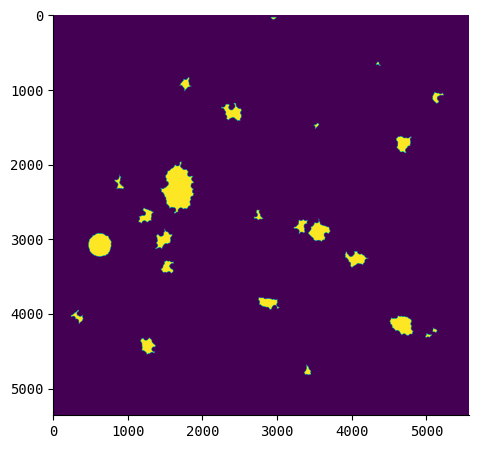

In [6]:
fig, ax = plt.subplots(figsize=(x/1000, y/1000))
ax.imshow(bin_image)

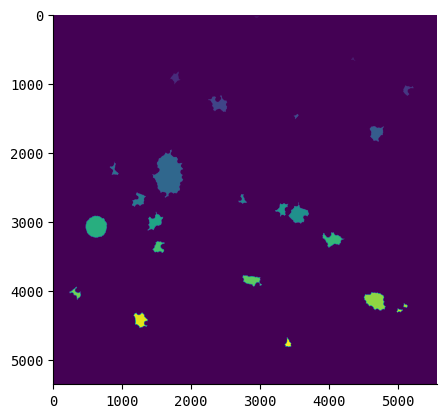

In [7]:
label_img = measure.label(bin_image)
props = measure.regionprops(label_img)

# plot labelled_img
fig, ax = plt.subplots()
ax.imshow(label_img)

In [8]:
area_thresh = 3000 # (in pixels) only take regions with large enough areas

props_thresh = [region for region in props if region.area>area_thresh]
areas = np.array([region.area for region in props_thresh]) * (pixel_size**2)
centroids = np.array([region.centroid for region in props_thresh])
distances = cdist(centroids, centroids, metric="euclidean") * pixel_size
np.fill_diagonal(distances, np.inf)
nearest_distances = np.min(distances, axis=1)
print(nearest_distances)

[323.04344477 333.43839132 323.04344477 333.43839132 247.93349046
 246.72257359 170.48207987 257.21890266 107.45768447 107.45768447
 162.53045233 318.43437453 269.15551092 162.53045233 462.15744085
 439.52186519 471.01814264 439.52186519 462.15744085]


Text(0.5, 0, 'Nearest distances between clusters (microns)')

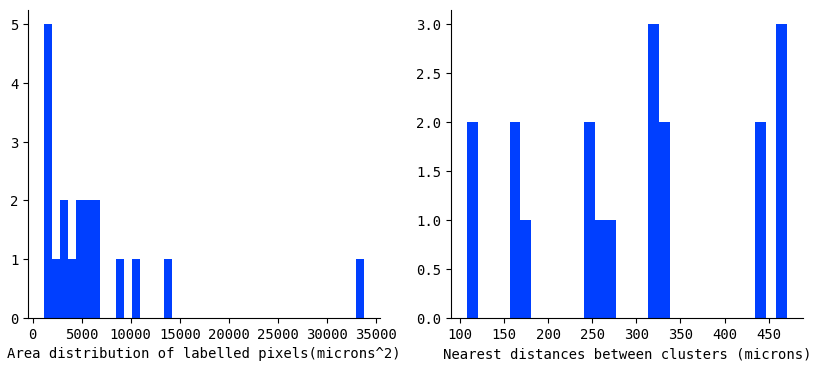

In [9]:
# plot area distribution
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(areas, bins=40)
ax[0].set_xlabel("Area distribution of labelled pixels(microns^2)")
ax[1].hist(nearest_distances, bins=30)
ax[1].set_xlabel("Nearest distances between clusters (microns)")

In [10]:
# claculate ellipse area instead of labelled image
minor_axis_lengths = np.array([region.axis_minor_length for region in props_thresh]) * pixel_size
major_axis_lengths = np.array([region.axis_major_length for region in props_thresh]) * pixel_size
ellipse_area = np.pi * minor_axis_lengths/2 * major_axis_lengths/2

Text(0.5, 0, 'Nearest distances between clusters (microns)')

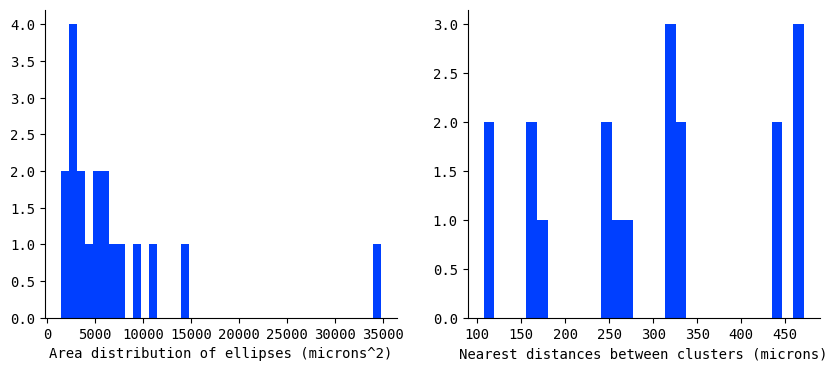

In [11]:
# plot area distribution
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(ellipse_area, bins=40)
ax[0].set_xlabel("Area distribution of ellipses (microns^2)")
ax[1].hist(nearest_distances, bins=30)
ax[1].set_xlabel("Nearest distances between clusters (microns)")

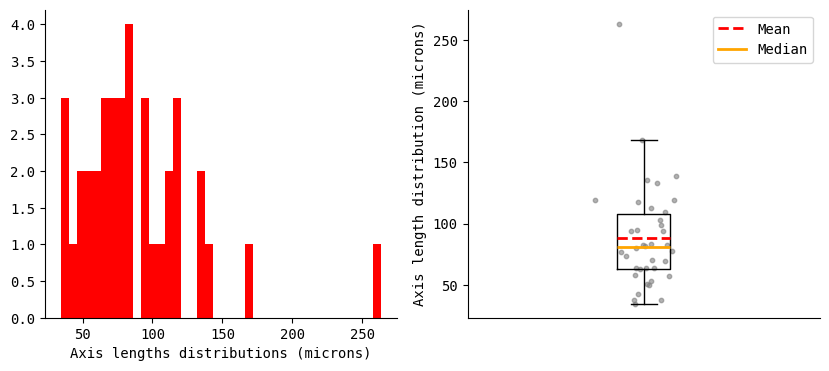

In [12]:
axis_lengths = np.concatenate((minor_axis_lengths, major_axis_lengths))
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(axis_lengths, bins=40, color="red")
ax[0].set_xlabel("Axis lengths distributions (microns)")
ax[1].boxplot(axis_lengths,
              showmeans=True,          # show the mean
              meanline=True,           # draw mean as a line instead of a point
              showfliers=False,
              meanprops={'color': 'red', # color of the mean line
                         'linestyle': '--',   # dashed line
                         'linewidth':2},
              medianprops={'color':'orange',
                           'linewidth':2})      # thickness
# add scatter plots
jittered_x = np.random.normal(1, 0.05, size=len(axis_lengths))  # Add jitter to x
ax[1].scatter(jittered_x, axis_lengths, color='gray', alpha=0.6, s=10)

ax[1].set_xticks([])
ax[1].set_ylabel("Axis length distribution (microns)")

legend_elements = [
    Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='Mean'),
    Line2D([0], [0], color='orange', linestyle='-', linewidth=2, label='Median')
]
ax[1].legend(handles=legend_elements, loc='upper right')


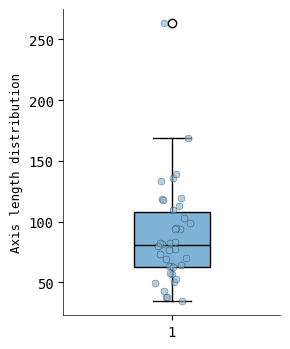

In [ ]:
# REPLOT BAR PLOT
from matplotlib.patches import Patch
plt.style.use('seaborn-v0_8-bright')
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 12

# Configuration
box_edge_color = 'black'
fill_color = '#7FB3D5'  # Use the first color
jitter_strength = 0.04
label = 'Inner Peak'  # Update accordingly
tick_label = 'Edge'   # X-axis label for the one position

# Example data (replace with your actual data)
data = axis_lengths  # or outers

plt.figure(figsize=(3, 3.6))

xpos = 1  # Single position for the plot

# Jittered scatter points
plt.scatter(np.random.normal(xpos, jitter_strength, size=len(data)), data,
            alpha=0.6, color=fill_color, edgecolor='black',
            linewidth=0.3, s=25, zorder=3)

# Boxplot
bp = plt.boxplot(data, positions=[xpos], widths=0.35, patch_artist=True, zorder=2)

# Styling the box
for patch in bp['boxes']:
    patch.set_facecolor(fill_color)
    patch.set_edgecolor(box_edge_color)

for element in ['whiskers', 'caps', 'medians']:
    for line in bp[element]:
        line.set_color(box_edge_color)

# Axis setup
# plt.xticks([xpos], [tick_label])
plt.ylabel("Axis length distribution")

# Legend
legend_patch = Patch(facecolor=fill_color, edgecolor='black', label=label)

plt.tight_layout()
plt.show()

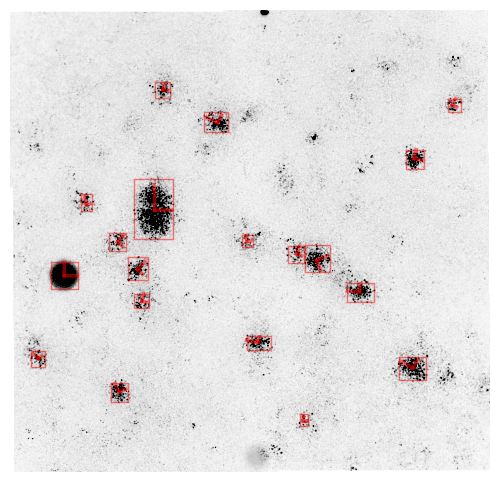

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(tbxt, cmap="Greys", vmin=np.percentile(tbxt, 1), vmax=np.percentile(tbxt, 99))

for i in range(len(props)):
    region = props[i]
    if region.area >= area_thresh: # check the area threshold

        y0, x0 = region.centroid
        orientation = region.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * region.axis_minor_length
        y1 = y0 - math.sin(orientation) * 0.5 * region.axis_minor_length
        x2 = x0 - math.sin(orientation) * 0.5 * region.axis_major_length
        y2 = y0 - math.cos(orientation) * 0.5 * region.axis_major_length

        ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5, alpha=0.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5, alpha=0.5)
        ax.plot(x0, y0, 'g', markersize=5)

        minr, minc, maxr, maxc = region.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, 'r', linewidth=1, alpha=0.5)
plt.axis("off")
plt.show()